In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(8155, 28)
(8155, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, 24] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.68696810e-02,
       -1.00021402e-01,  1.75815529e-02,  1.65718385e-04,  1.71657945e-02,
        3.60887973e-03,  2.38365782e-01,  1.88972370e-01, -4.30276655e-01,
        2.34579479e-01, -1.71742532e-01, -4.30644984e-01, -2.50112940e-01,
        1.60852297e-01, -4.29579197e-01, -2.61250256e-01, -1.35911712e-01,
       -4.30093734e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_RR_swinging[0, :]

array([ 0.01396513,  0.00175821,  0.02581932, -0.0072911 ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9949765250289648
RMSE:  0.0028300922720583344
The lowest error is:  1.7474091059677122e-06
The highest error is:  0.03803410248067507
The avg. error is:  0.001289910473470727


In [11]:
model_rr_relative_swinging_x.coef_

array([[ 3.84661705e-03,  0.00000000e+00, -5.55111512e-17,
         2.14041386e-01,  5.55111512e-17,  1.66533454e-16,
         1.37347913e-01,  1.22308010e-01, -6.28149193e-03,
        -3.05815018e-01,  1.13662666e-01,  2.97044394e-02,
        -4.40460998e-01, -5.68849983e-02]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([-0.20351494])

Text(0, 0.5, 'Predictions')

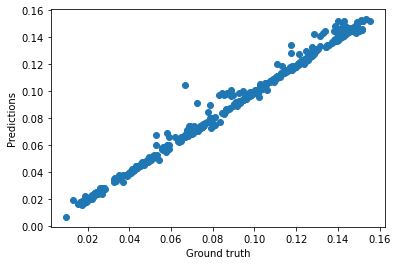

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [17]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8114546892876624
RMSE:  0.0018541783122656657
The lowest error is:  4.272915586273074e-06
The highest error is:  0.018854620641927278
The avg. error is:  0.0009402949723937976


In [18]:
model_rr_relative_swinging_y.coef_

array([[ 6.11004943e-03, -4.51028104e-17,  5.55111512e-17,
         2.50236691e-02,  8.32667268e-17,  1.11022302e-16,
         6.09178223e-02,  1.63966224e-01, -2.88520490e-02,
        -1.85752265e-01, -1.95492323e-01,  1.44730707e-01,
         4.23508864e-02, -4.10894540e-01]])

In [19]:
model_rr_relative_swinging_y.intercept_

array([-0.19817056])

Text(0, 0.5, 'Predictions')

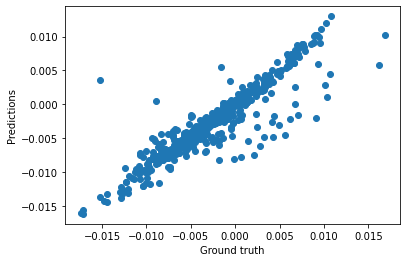

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")